In [14]:
import operator
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [15]:
#  below is the dictionary which serves as values for 'params'
param_grid_dict = {
    'LogisticRegression': {
        'penalty': ['l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['newton-cg', 'sag', 'saga']
    },
    'DecisionTreeClassifier': {
        'max_depth': list(range(5, 21, 5)),
        'max_features': list(range(5, 20, 15)),
    },
    'SVC': {
        'C': list(range(1, 20, 2)),
        'kernel': ['linear', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'RandomForestClassifier': {
        'n_estimators': list(range(500, 750, 1000)),
        'max_features': list(range(5, 50, 5)),
        'max_depth': [1, 10, 20, 30, 40]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [2, 5, 7, 10, 15, 20, 30, 40, 50],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3, 5],
    },
    'BernoulliNB': {
        'alpha': [1.0, 0.5, 0],
        'fit_prior': [True, False]
    },
    'GaussianNB': {},
    'SGDClassifier': {
        'loss': ['hinge', 'log', 'modified_huber'],
        'penalty': ["l2", "elasticnet"]
    }
}

In [16]:
def perform_one_hot_encoding_column(data, column_name):
    """
    While one-hot encoding solves the problem of unequal weights given to categories within a feature,
    it is not very useful when there are many categories, as that will result in formation of as many new columns,
    which can result in the curse of dimensionality.
    The concept of the “curse of dimensionality” discusses that in
    high-dimensional spaces some things just stop working properly.
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    X = enc.fit_transform(data[column_name].values.reshape(-1, 1)).toarray()
    dfOneHot = pd.DataFrame(X, columns=["enc_" + column_name.lower() + "_" + str(int(i)) for i in range(X.shape[1])])
    data = pd.concat([data, dfOneHot], axis=1)
    data = data.drop(column_name, axis=1)
    return data

In [17]:
def perform_handling_missing_values(data):
    data = data.replace('?', np.NaN)
    null_columns = data.columns[data.isnull().any()]
    for column_name in null_columns:
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp.fit(data[[column_name]])
        data[column_name] = imp.transform(data[[column_name]]).ravel()
    return data

In [18]:
def perform_handling_categorical_data(feature_data, label_data, encoder):
    # 1. performing one hot encoding
    feature_data = perform_one_hot_encoding_column(feature_data, 'workclass')
    feature_data = perform_one_hot_encoding_column(feature_data, 'education')
    feature_data = perform_one_hot_encoding_column(feature_data, 'marital-status')
    feature_data = perform_one_hot_encoding_column(feature_data, 'occupation')
    feature_data = perform_one_hot_encoding_column(feature_data, 'relationship')
    feature_data = perform_one_hot_encoding_column(feature_data, 'race')
    feature_data = perform_one_hot_encoding_column(feature_data, 'age_group')
    # feature_data = perform_one_hot_encoding_column(feature_data, 'native-country')

    # 2. performing label encoding
    feature_data['enc_gender'] = feature_data['gender'].map({'Male': 1, 'Female': 0})
    label_data = label_data.map({'<=50K': 1, '>50K': 0})
    feature_data = feature_data.drop(["gender"], axis=1)
    if encoder == 'OneHotEncoding':
        #  part of RESEARCH
        feature_data = perform_one_hot_encoding_column(feature_data, 'native-country')
        feature_data = perform_one_hot_encoding_column(feature_data, 'capital-gain')
        feature_data = perform_one_hot_encoding_column(feature_data, 'capital-loss')
    elif encoder == 'LabelEncoder':
        #  part of RESEARCH
        label_enc = LabelEncoder()
        feature_data['native-country'] = label_enc.fit_transform(feature_data['native-country'])
        feature_data['capital-gain'] = label_enc.fit_transform(feature_data['capital-gain'])
        feature_data['capital-loss'] = label_enc.fit_transform(feature_data['capital-loss'])
    elif encoder == 'BinaryEncoder':
        #  part of RESEARCH
        binary_enc = ce.BinaryEncoder(cols=['native-country'])
        native_country_enc = binary_enc.fit_transform(feature_data['native-country'])
        feature_data = feature_data.drop('native-country', axis=1)

        binary_enc = ce.BinaryEncoder(cols=['capital-gain'])
        capital_gain_enc = binary_enc.fit_transform(feature_data['capital-gain'])
        feature_data = feature_data.drop('capital-gain', axis=1)

        binary_enc = ce.BinaryEncoder(cols=['capital-loss'])
        capital_loss_enc = binary_enc.fit_transform(feature_data['capital-loss'])
        feature_data = feature_data.drop('capital-loss', axis=1)

        feature_data = pd.concat([feature_data, native_country_enc, capital_gain_enc, capital_loss_enc], axis=1)
    else:
        # 3. perform binary encoding on capital-gain and capital-loss column
        # this method is implemented because the data is highly skewed and there are many unique values in the columns.
        # if one-hot-encoding method is applied here then there will be dimentionality explosion.
        # So binary encoding is applied where all the non-zero values are converted to 1 and 0's remain 0
        feature_data['capital-gain'] = feature_data['capital-gain'].apply(lambda x: 1 if x != 0 else 0)
        feature_data['capital-loss'] = feature_data['capital-loss'].apply(lambda x: 1 if x != 0 else 0)

        # As there are many entries where there is United States, that's why data is highly skewed.
        # I convert this to binary column that wherever there is United states it will be replaced by 1, otherwise 0
        feature_data['native-country'] = feature_data['native-country'].apply(lambda x: 1 if x == 'United States' else 0)

    print('Handling categorical data done')
    return feature_data, label_data

In [19]:
def convert_to_age_groups(x):
    binning_dict = {
        tuple(range(10, 31)): '10-30',
        tuple(range(31, 51)): '31-50',
        tuple(range(51, 71)): '51-70',
        tuple(range(71, 91)): '71-90',
    }
    # print(binning_dict.keys())
    keys = binning_dict.keys()
    for k in keys:
        if x in k:
            x = binning_dict[k]
            break
    return x

In [20]:
def perform_outlier_detection(feature_data, column_name="all-columns"):
    sns.boxplot(data=feature_data.loc[:, ~feature_data.columns.str.contains('enc_') & ~feature_data.columns.str.contains('capital-') & ~feature_data.columns.str.contains('native')])
    if column_name == "all-columns":
        plt.xlabel("all df")
        plt.ylabel("All values")
    else:
        plt.xlabel("df['" + feature_data.name + "']")
        plt.ylabel(str(feature_data.name))
    plt.savefig(f'{column_name}.png', bbox_inches='tight')

In [21]:
def perform_data_scaling(data):
    scaler = MinMaxScaler()
    data[['hours-per-week']] = scaler.fit_transform(data[['hours-per-week']])
    columns = data.columns
    if 'capital-gain' in columns:
        data[['capital-gain']] = scaler.fit_transform(data[['capital-gain']])
    if 'capital-loss' in columns:
        data[['capital-loss']] = scaler.fit_transform(data[['capital-loss']])
    data[['educational-num']] = scaler.fit_transform(data[['educational-num']])
    print('data scaling done')
    return data

In [22]:
def perform_data_standardization(feature_data):
    scaler = StandardScaler()
    scaler_data = scaler.fit_transform(feature_data)
    new_data = pd.DataFrame(data=scaler_data, columns=feature_data.columns)
    print('data standardization done')
    return new_data

In [23]:
def preprocess_data(data, encoder="auto"):
    """
    This function takes care of pre-processing of data. Various steps of pre-processing are handled here.
    Drop some rows to reduce data size, converting age to age-groups, handling missing values,
    handing categorical values; converting categorical values to numerical using encoding techniques, scaling of data,
    data standardization and finally outlier detection.
    Feature selection not be part of this process as majority of the columns are categorical columns.
    """
    # reducing data. Consider only rows having Occupation as Armed-Forces, handlers-cleaners, Machine-op-inspct,
    # Prof-specialty, Tech-support
    # Get names of indexes for which column Age has value 30
    rows_to_drop = ["Adm-clerical", "Craft-repair", "Exec-managerial", "Farming-fishing", "Other-service",
                    "Priv-house-serv", "Protective-serv", "Sales", "Transport-moving"]
    index_names = data[data['occupation'].isin(rows_to_drop)].index
    # Delete these row indexes from dataFrame
    data = data.drop(index_names, inplace=False)
    data = data.reset_index()
    data = data.drop('index', axis=1)

    feature_data = data.drop(['income'], axis=1)
    label_data = data['income']

    # binning age column
    feature_data['age_group'] = feature_data['age'].apply(lambda x: convert_to_age_groups(x))
    # dropping unwanted_columns
    feature_data = feature_data.drop(['fnlwgt', 'age'], axis=1)
    # handling missing values
    feature_data = perform_handling_missing_values(feature_data)
    # converting categorical data to labels
    feature_data, label_data = perform_handling_categorical_data(feature_data, label_data, encoder)
    # scaling data
    feature_data = perform_data_scaling(feature_data)
    # standardizing data
    feature_data = perform_data_standardization(feature_data)
    if encoder == 'auto':
        # outlier detection
        perform_outlier_detection(feature_data)

    # feature selection
    # clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, verbose=1)
    # clf.fit(feature_data, label_data)
    #
    # feature_importance_list = clf.feature_importances_
    #
    # sorting_indices = np.argsort(feature_importance_list)
    # print(sorting_indices)
    print('data preprocessing completed')
    return feature_data, label_data

In [24]:
def get_model_accuracy(train_features, train_labels, test_features, test_labels, clf):
    """
    This is a generalised function which predicts values for the model object passed
    """
    clf.fit(train_features, train_labels)
    predicted = clf.score(test_features, test_labels)
    return clf, predicted

In [25]:
def get_top_performing_model(train_features, train_labels, test_features, test_labels):
    """
    In this function I am evaluating my data on 7 different classifiers. These are:
    1. k-NN
    2. Bernoulli Naive Bayes
    3. Gaussian Naive Bayes
    4. RandomForestClassifier
    5. DecisionTreeClassifier
    6. LogisticRegression
    7. SGD
    :param train_features:
    :param train_labels:
    :param test_features:
    :param test_labels:
    :return: classifier object
    """
    classifier_dict = {}
    print('------------------------Calculating KNN-------------------')
    knn_clf = KNeighborsClassifier()
    knn_clf, knn_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels, knn_clf)
    classifier_dict[knn_clf] = knn_predicted
    print('kNN accuracy=', knn_predicted)
    #
    print('-------------Calculating Bernoulli, Gaussian Naive Bayes-----------------')
    nb_clf = BernoulliNB()
    nb_clf, bernoulli_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels, nb_clf)
    classifier_dict[nb_clf] = bernoulli_predicted
    print('BernoulliNB accuracy=', bernoulli_predicted)

    nb_clf = GaussianNB()
    nb_clf, gaussian_nb_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels, nb_clf)
    classifier_dict[nb_clf] = gaussian_nb_predicted
    print('GaussianNB accuracy=', gaussian_nb_predicted)

    print('------------------Calculating RandomForestClassifier-----------------')
    rf_clf = RandomForestClassifier(random_state=0)
    rf_clf, random_forest_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels,
                                                         rf_clf)
    classifier_dict[rf_clf] = random_forest_predicted
    print('RandomForestClassifier accuracy=', random_forest_predicted)

    print('------------------Calculating DecisionTreeClassifier-----------------')
    dt_clf = DecisionTreeClassifier(random_state=0)
    dt_clf, decision_tree_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels,
                                                         dt_clf)
    classifier_dict[dt_clf] = decision_tree_predicted
    print('DecisionTreeClassifier accuracy=', decision_tree_predicted)

    print('------------------Calculating LogisticRegression-----------------')
    lr_clf = LogisticRegression(random_state=0)

    lr_clf, logistic_regression_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels,
                                                               lr_clf)
    classifier_dict[lr_clf] = logistic_regression_predicted
    print('LogisticRegression accuracy=', logistic_regression_predicted)

    # print('------------------Calculating SVC-----------------')
    # svc_clf = SVC(random_state=0, C=1.0)
    # svc_clf, svc_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels, svc_clf)
    # classifier_dict[svc_clf] = svc_predicted
    # print('SVC accuracy=', svc_predicted)

    print('------------------Calculating SGD-----------------')
    sgd_clf = SGDClassifier(random_state=0)
    sgd_clf, sgd_predicted = get_model_accuracy(train_features, train_labels, test_features, test_labels,
                                                sgd_clf)
    classifier_dict[sgd_clf] = sgd_predicted
    print('Stochastic Gradient Descent accuracy=', sgd_predicted)

    max_accuracy_classifier = dict(sorted(classifier_dict.items(), key=operator.itemgetter(1), reverse=True)[:3])
    return max_accuracy_classifier

Handling categorical data done
data scaling done
data standardization done
data preprocessing completed
Now splitting data...


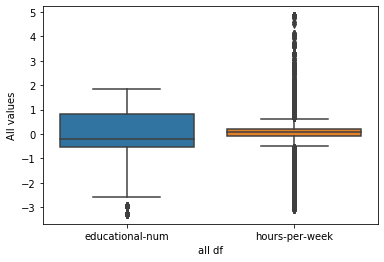

In [26]:
"""
This is the main driver function which calls different functions and gets output which is fed as input to other.
This function performs data preprocessing, splits train and test data, calculates accuracy of 8 different ML
models, selects top 3 models, performs hyper-parameter tuning on these models, calculates confusion matrix,
displays classification report, performs research topic which is implementing different encoding techniques,
displays the accuracy for each encoding technique used.
"""
main_data = pd.read_csv("adult.csv")  # reading csv file
feature_data, label_data = preprocess_data(main_data)  # pre-processing data to make it stable

print('Now splitting data...')
train_features, test_features, train_labels, test_labels = train_test_split(feature_data, label_data, test_size=0.2,
                                                                            random_state=0)

In [ ]:
#  calculates accuracy for 8 different models and return top 3 performing models
top_models = get_top_performing_model(train_features, train_labels, test_features, test_labels)
print()

In [ ]:
print(f'According to accuracies top performing models are:')
#  the below part of code will perform hyper-parameter tuning for the top 3 models selected and calculate accuracy
for model in top_models:
    # if type(model).__name__ == 'LogisticRegression':
    print('-----------------------', type(model).__name__, '----------------------')
    gridS = GridSearchCV(model, param_grid=param_grid_dict[type(model).__name__], cv=5, verbose=False, n_jobs=-1)
    grid_result = gridS.fit(feature_data, label_data)

    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    print('Confusion matrix for the model')
    y_pred = cross_val_predict(gridS, feature_data, label_data)
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(label_data, y_pred).ravel()
    print(true_neg, false_pos, false_neg, true_pos)
    print('Classification report')
    precision_scores = cross_val_score(gridS, feature_data, label_data, scoring='precision')
    recall_scores = cross_val_score(gridS, feature_data, label_data, scoring='recall')
    f_scores = cross_val_score(gridS, feature_data, label_data, scoring='f1')
    print('Average precision score:', precision_scores.mean())
    print('Average recall score:', recall_scores.mean())
    print('Average f1 score:', f_scores.mean())

print('Evaluated baseline models')
print()

According to accuracies top performing models are:
----------------------- LogisticRegression ----------------------


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.8507337796086509
Best Params:  {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'saga'}
Confusion matrix for the model


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


2587 1397 926 10626
Classification report


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in versio

Average precision score: 0.8838595052066663
Average recall score: 0.9198404642185478
Average f1 score: 0.901473369471467
----------------------- SGDClassifier ----------------------
Best Score:  0.8448764160659115
Best Params:  {'loss': 'log', 'penalty': 'elasticnet'}
Confusion matrix for the model


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


2708 1276 1139 10413
Classification report


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Average precision score: 0.8908526117835306
Average recall score: 0.9014023231161638
Average f1 score: 0.8960921488865377
----------------------- KNeighborsClassifier ----------------------
Best Score:  0.8432028836251287
Best Params:  {'algorithm': 'brute', 'n_neighbors': 50, 'p': 1}
Confusion matrix for the model


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


2600 1384 1028 10524
Classification report


/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/shrenik/ai_course/ML/SD_R00183334_Assignment2/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
#  the below part of code will now take top 3 models and change the encoding techniques and notes down accuracy for
#  each model when used with a particular encoder
print('------------Researching different encoding techniques----------------')
encoder_list = ['LabelEncoder', 'OneHotEncoding', 'BinaryEncoder']
for model in top_models:
    # if type(model).__name__ == 'LogisticRegression':
    for encoder in encoder_list:
        print('-----------------------', type(model).__name__, '----------------------')
        print(f"Encoder={encoder}")
        feature_data, label_data = preprocess_data(main_data, encoder=encoder)
        gridS = GridSearchCV(model, param_grid=param_grid_dict[type(model).__name__], cv=5, verbose=False, n_jobs=-1)
        grid_result = gridS.fit(feature_data, label_data)
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)